In [1]:
import math

import pandas as pd
import yfinance as yf
import numpy as np
from tqdm import tqdm
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# 데이터 불러오기

실제 DB에는     
실제 데이터 - 21년도초부터~오늘까지 데이터로 한번에 올라가 있음,    
예측 데이터 - 21년도초부터~예측일까지 데이터,   
평가지표 이렇게 올라가 있음 

## 학습데이터 불러오기

In [2]:
import pandas as pd
import yfinance as yf
start = '2022-01-01'
end = '2023-12-31'
symbol = 'AAPL' # "005930.KS"
total_train_df = yf.download(symbol, start, end)
total_train_df = total_train_df.rename(columns={'Adj Close': 'Adj_Close'})
total_train_df['ds'] = pd.to_datetime(total_train_df.index, format = '%Y-%m-%d')
total_train_df['y'] = total_train_df['Close']

[*********************100%%**********************]  1 of 1 completed


## 예측값 확인용 데이터 불러오기

### 예측할 날짜 기간 정하기

In [3]:
fcast_time = 11 #365 # 365일 예측
freq_option = 'D'

### 데이터 불러오기

In [4]:
start_r = '2024-01-01' #위 학습 데이터 불러오면 자동으로 계산되게 할 예정
end_r = '2024-01-10' # 위의 값 바꾸면 자동으로 계산되서 적용되게 설정할 예정
ticker_r = 'AAPL'

df_recent = yf.download(ticker_r, start=start_r, end=end_r)
df_recent['ds'] = pd.to_datetime(df_recent.index, format = '%Y-%m-%d')
df_recent['y'] = df_recent['Close']

[*********************100%%**********************]  1 of 1 completed


# 데이터 학습 형태에 맞게 만들어 주기

In [5]:
total_train_df_input = total_train_df[['ds','y']]

# 휴일 df 만들기
AAPL이 NMS이라 미국의 휴일 데이터 가져와서 만듦

In [6]:
us_holidays = make_holidays_df(
    year_list=[2022 + i for i in range(3)], country='US'
)

# 하이퍼파라미터 조절

total_train_df를 8:2로 train, test로 나눔
그리고 파라미터는 daily_seasonality = True, holidays=us_holidays 고정으로 설정해주고,   
파라미터 그리드 리스트 : changepoint_prior_scale, holidays_prior_scale, n_changepoints, seasonality_mode, seasonality_prior_scale   
평가지표는 mse를 사용

In [7]:
# # 데이터를 8:2 비율로 나누기
# train_size = int(len(total_train_df_input) * 0.8)
# df_train = total_train_df_input[:train_size]
# df_test = total_train_df_input[train_size:]

# # 하이퍼파라미터 그리드 생성
# '''
# 하이퍼파라미터 기본값
# changepoint_prior_scale = 0.05, holidays_prior_scale = 10.0, 
# n_changepoints = 25, seasonality_mode = 'additive', 
# seasonality_prior_scale = 10.0
# '''
# param_grid = {
#     'changepoint_prior_scale': [0.7, 0.3, 0.15, 0.05],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'n_changepoints': [10, 25, 50],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # 모든 하이퍼파라미터 조합에 대해 모델 생성 및 평가
# all_params = ParameterGrid(param_grid)
# mse_scores = []
# best_score = np.inf
# best_params = None

# for params in tqdm(all_params):
#     # print("현재 파라미터:", params)
#     model = Prophet(daily_seasonality=True, holidays=us_holidays, **params).fit(df_train)
#     forecast_test = model.predict(df_test)
#     mse = mean_squared_error(df_test['y'], forecast_test['yhat'])
#     mse_scores.append(mse)
#     # print('mse값은 ', mse)

#     if mse < best_score:
#         best_score = mse
#         best_params = params
#         print(best_score, params)

# print('Best params:', best_params, 'mse: ',best_score)

# 모델 학습 및 예측 평가
학습은 위 total_train_df를 학습, fcast_time&freq_option 만큼 예측 

## 모델 생성 및 학습
그리고 추가로 holidays 요소도 추가하기 위해 추가적으로 파라미터에 포함시켜줌

In [8]:
# model_prophet = Prophet(changepoint_prior_scale=0.1, daily_seasonality = True, holidays=us_holidays, holidays_prior_scale=0.02, 
#                          n_changepoints=73, seasonality_mode='multiplicative', seasonality_prior_scale=0.13)
model_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality = True, holidays=us_holidays) #, holidays_prior_scale=0.01, 
                         # n_changepoints=50, seasonality_mode='multiplicative', seasonality_prior_scale=0.13)
model_prophet.fit(total_train_df_input)

12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing


## 예측하기 위해 날짜 df 만들어주기
make_future_dataframe을 이용해서 생성   
+ 원래 실제 주식 데이터에는 주말, 공휴일 날짜에 해당하는 데이터는 아예 거래소가 안 열려서 없는 관계로   
예측할 날짜 데이터를 넣어줄 때 실제 데이터에 해당하는 기간의 날짜들은 실제 데이터 날짜들과 동일하게 주말, 공휴일이 제외되어있으나,  
추가로 만들어준 예측에 해당하는 기간의 날짜들은 주말, 공휴일 제외되지 않고 빠짐없이 만들어지는 것을 확인하여 수동으로 추가로 제외해주었습니다
    

In [9]:
future = model_prophet.make_future_dataframe(periods = fcast_time, freq = freq_option)
future = future[future['ds'].dt.dayofweek < 5] # 주말 제외 작업
future = future[~future['ds'].isin(us_holidays['ds'])] # 공휴일 제외 작업

## 예측 및 그래프

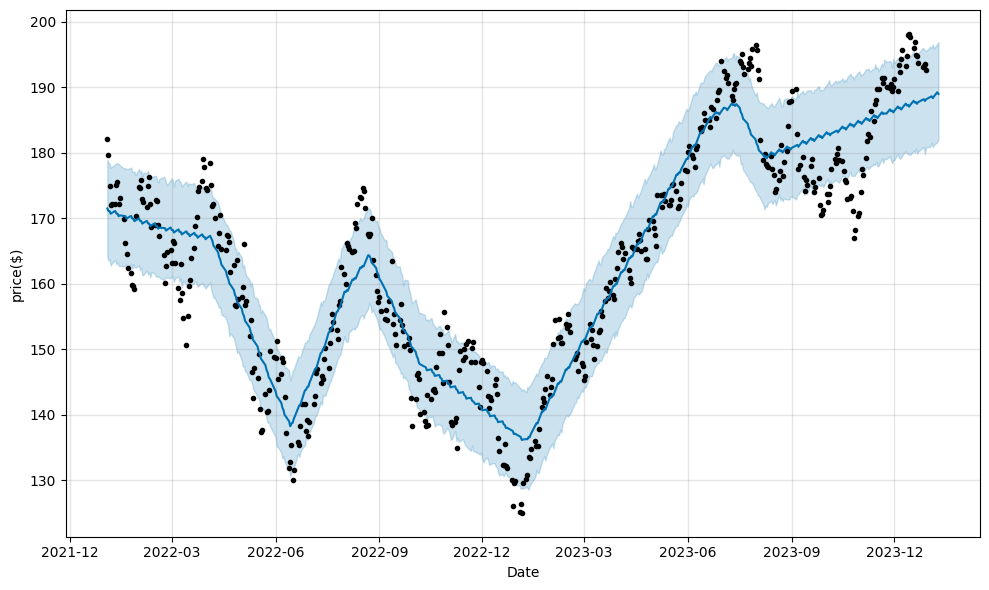

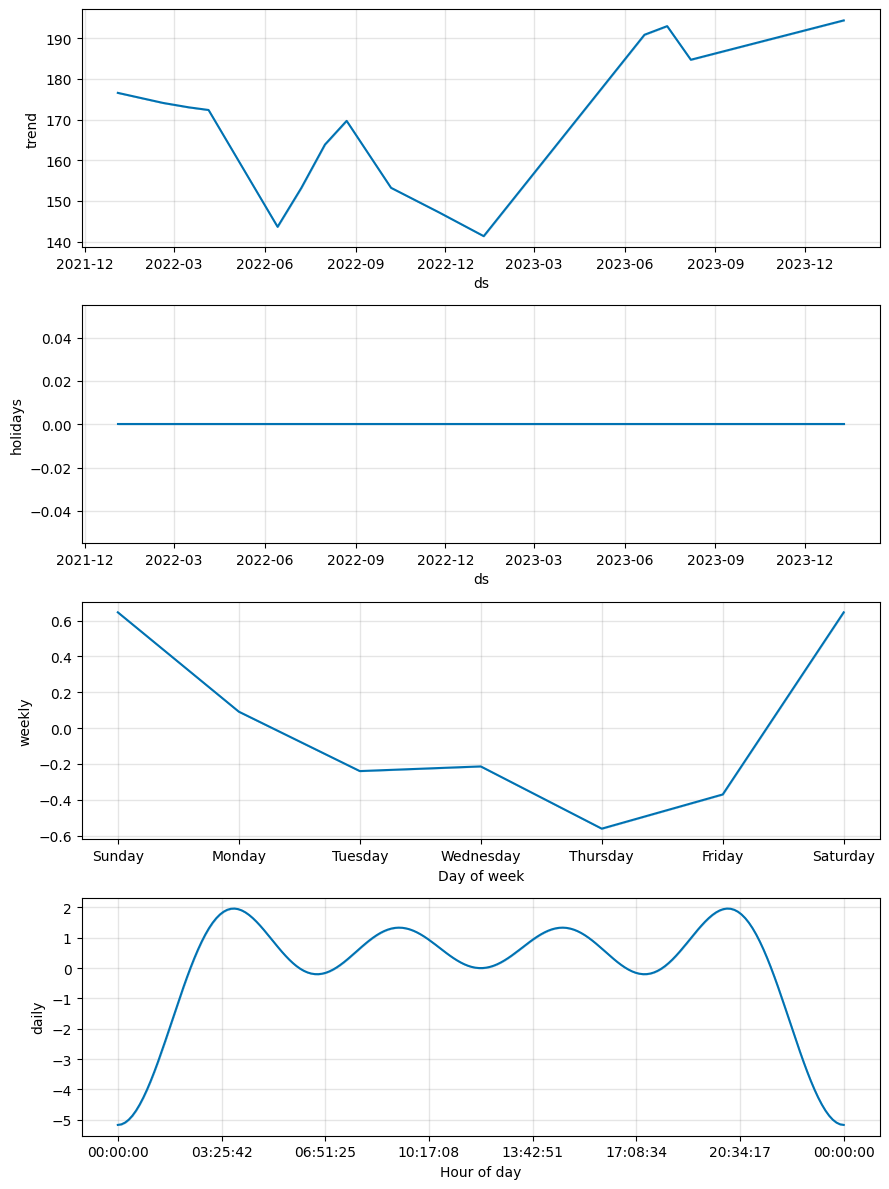

In [10]:
df_forecast = model_prophet.predict(future)
model_prophet.plot(df_forecast, xlabel = 'Date',ylabel ='price($)')
model_prophet.plot_components(df_forecast);

# 예측 평가

## 예측에 쓸 값들만 따로 떼어서 새로 data 만들어주기
test_data : 예측기간에 해당하는 실제 값     
fc : 예측기간에 해당하는 예측 값

In [24]:
df_forecast.set_index('ds', inplace=True)
test_data = df_recent['y']
fc = df_forecast[df_forecast.index>='2024-01-01'].iloc[:len(test_data)]['yhat']

## 예측 평가 지표 계산
MSE, MAE, RMSE, MAPE, R2_score sklearn.metrics 메소드들 사용하여 계산

In [25]:
mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)
mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)
mape = mean_absolute_percentage_error(test_data, fc)
print('MAPE: ' , '{:.2f}%'.format(mape*100))
r2score = r2_score(test_data,fc)
print('r2 score: ', r2score)

MSE:  25.08739473773476
MAE:  4.744378759636547
RMSE:  5.008731849254336
MAPE:  2.59%
r2 score:  -7.0114104512216535
